In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib

In [2]:
from sklearn.metrics import mean_squared_error as MSE

In [3]:
from preprocessamento import *

In [16]:
from metricas import mape, pocid

In [4]:
serie_name = 'star'
print('Série:', serie_name)
endereco = serie_name+'.txt'
dados = pd.read_csv(endereco, delimiter=' ', header=None)
serie = dados[0]
serie_normalizada = normalise(serie)

train, test = split_serie_less_lags(serie_normalizada, 0.75)

max_lag = 20
lags_acf = select_lag_acf(serie_normalizada, max_lag)
max_sel_lag = lags_acf[0]

train_lags = create_windows(train, max_sel_lag+1)

test_data = create_windows(test, max_sel_lag+1)

train_data,  val_data = select_validation_sample(train_lags, 0.34)

Série: star
LAGS [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [5]:
x_train = train_data[:,0:-1]
x_train = x_train[:,lags_acf]  
y_train = train_data[:,-1]
x_val = val_data[:,0:-1]
x_val = x_val[:,lags_acf]
y_val = val_data[:,-1]

In [11]:
x_test = test_data[0:, 0:-1]
x_test = x_test[:, lags_acf]
y_test = test_data[:, -1]

In [6]:
def gerar_elm(neuronios, alpha, rbf_w, func_at):
    from sklearn_extensions.extreme_learning_machines.elm import ELMRegressor
    elm = ELMRegressor(n_hidden =neuronios, alpha =alpha, rbf_width = rbf_w, activation_func  = func_at)
    return elm

In [7]:
def train_modelo(modelo, x_train, y_train, x_val, y_val, num_ex=5):

    melhor_mse = np.Inf
    for i in range(0, num_ex):
        modelo.fit(x_train, y_train)
        prev_v = modelo.predict(x_val)
        novo_mse  = MSE(y_val, prev_v)
        if novo_mse < melhor_mse:
            melhor_mse = novo_mse
            melhor_modelo = modelo

    return melhor_modelo, melhor_mse

In [8]:
neuronios = [2, 5] #[2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
alpha = [0.001] #[0.001, 0.1, 0.5, 0.6, 1, 10, 50]
rbf_w = [0.001] #[0.001, 0.1, 0.5,  1]
func_at =  ['tanh']   #['tanh', 'sigmoid', 'gaussian', 'multiquadric', 'inv_multiquadric']

best_result = np.Inf
for i in range(0,len(neuronios)):
    for j in range(0,len(alpha)):
        for l in range(0,len(rbf_w)):
            for m in range(0,len(func_at)):
                modelo_elm = gerar_elm(neuronios[i], alpha[j], rbf_w[l], func_at[m])
                modelo_treinado, mse_val = train_modelo(modelo_elm, x_train, y_train, x_val, y_val)
                print(mse_val)
                if mse_val < best_result:
                        best_result = mse_val
                        select_model = modelo_treinado
                        print('melhor configuração. Neur:', neuronios[i], 'Alp:', alpha[j], 'Rbf:', rbf_w[l], 'Funç', func_at[m])

0.024181907601238447
melhor configuração. Neur: 2 Alp: 0.001 Rbf: 0.001 Funç tanh
0.0008045142143920198
melhor configuração. Neur: 5 Alp: 0.001 Rbf: 0.001 Funç tanh


In [9]:
filename = serie_name+'_ELM_aula.sav'
joblib.dump(select_model, filename)

['star_ELM_aula.sav']

In [10]:
nome_modelo = filename
modelo_carregado = joblib.load(nome_modelo)

In [12]:
prev_test = modelo_carregado.predict(x_test)

In [18]:
pocid(y_test, prev_test)

68.75

In [19]:
mape(y_test, prev_test)

10.960361954683785

In [20]:
MSE(y_test, prev_test)

0.0014638419804477582

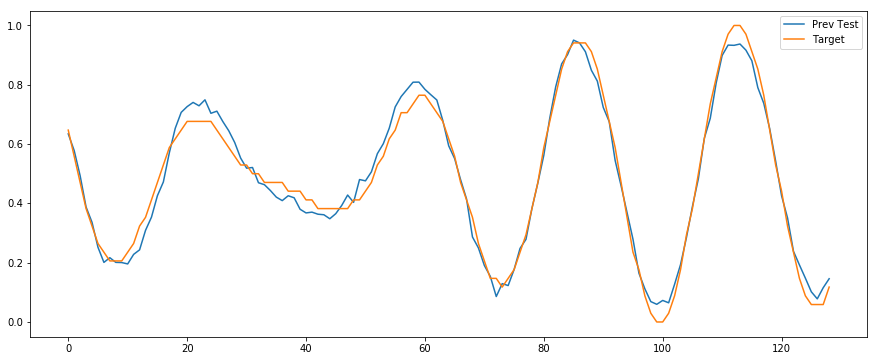

In [15]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6


plt.plot(prev_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()